In [14]:
import re 
import tldextract
import pandas as pd 
from urllib.parse import urlparse
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

In [13]:
main = pd.read_csv("malicious_phish.csv")
main

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [15]:
# Define a list of file paths and corresponding types
file_paths = [
    ("FinalDataset/URL/Benign_list_big_final.csv", "benign"),
    ("FinalDataset/URL/DefacementSitesURLFiltered.csv", "defacement"),
    ("FinalDataset/URL/Malware_dataset.csv", "malware"),
    ("FinalDataset/URL/phishing_dataset.csv", "phishing"),
    ("FinalDataset/URL/spam_dataset.csv", "spam")
]

# Initialize an empty list to store dataframes
dfs = []

# Iterate through the file paths and types
for file_path, url_type in file_paths:
    # Read the CSV file
    df = pd.read_csv(file_path, header=None)
    # Assign column names
    df.columns = ["url"]
    # Add a column for the URL type
    df["type"] = url_type
    # Append the dataframe to the list
    dfs.append(df)

dfs.append(main)
# Concatenate the list of dataframes into a single dataframe
merged_df = pd.concat(dfs, ignore_index=True)
merged_df.drop_duplicates(inplace=True)
merged_df.reset_index(drop=True, inplace=True)


df = merged_df
# Display the merged dataframe
merged_df.head()

,url,type
0,http://1337x.to/torrent/1048648/American-Snipe...,benign
1,http://1337x.to/torrent/1110018/Blackhat-2015-...,benign
2,http://1337x.to/torrent/1122940/Blackhat-2015-...,benign
3,http://1337x.to/torrent/1124395/Fast-and-Furio...,benign
4,http://1337x.to/torrent/1145504/Avengers-Age-o...,benign


In [16]:
print(df.info())
merged_df.type.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653046 entries, 0 to 653045
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     653046 non-null  object
 1   type    653046 non-null  object
dtypes: object(2)
memory usage: 10.0+ MB
None


type
benign        428080
defacement     95308
phishing       94092
malware        23645
spam           11921
Name: count, dtype: int64

## Preprocessing

### Removing duplicates and missing rows

In [17]:
print(f"Number of rows before preprocessing : {merged_df.shape[0]}")

df.dropna(inplace=True)
df.drop_duplicates(subset=['url'], inplace=True)

print(f"Number of rows after preprocessing : {merged_df.shape[0]}")

Number of rows before preprocessing : 653046
Number of rows after preprocessing : 653040


### Label Encoding

In [18]:
label_encoder = LabelEncoder()
df['type_encoded'] = label_encoder.fit_transform(df['type'])

In [20]:
df.to_csv("merged_encoded_dataset.csv", index=False)

In [32]:
df.type_encoded.value_counts()

type_encoded
0    428080
1     95308
3     94086
2     23645
4     11921
Name: count, dtype: int64

### Feature Engineering

In [54]:
def extract_features(url):
    parsed_url = urlparse(url)
    ext = tldextract.extract(url)
    return {
        'url_length': len(url),
        'num_digits': sum(c.isdigit() for c in url),
        'num_special_chars': len(re.findall(r'[^a-zA-Z0-9]', url)),
        'num_subdomains': parsed_url.netloc.count('.') - 1,
        'tld_length': len(ext.suffix),
        'path_length': len(parsed_url.path),
        'query_length': len(parsed_url.query),
        'num_query_params': parsed_url.query.count('=')
    }
    
    
# Apply feature extraction
df_features = df['url'].apply(lambda x: extract_features(x))
df_features = pd.DataFrame(df_features.tolist())

### Class Imbalance fixing

In [55]:
X = df_features
y = df['type_encoded']

# Address class imbalance using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert back to DataFrame
df_balanced = pd.DataFrame(X_resampled)
df_balanced['type_encoded'] = y_resampled

print(df_balanced['type_encoded'].value_counts())

type_encoded
0    428080
1    428080
2    428080
3    428080
4    428080
Name: count, dtype: int64


In [42]:
df_balanced

,url_length,num_digits,num_special_chars,num_subdomains,tld_length,path_length,query_length,num_query_params,type_encoded
0,83,18,16,0,2,68,0,0,0
1,83,23,17,0,2,68,0,0,0
2,83,22,17,0,2,68,0,0,0
3,83,18,19,0,2,68,0,0,0
4,83,18,17,0,2,68,0,0,0
...,...,...,...,...,...,...,...,...,...
2140395,59,13,11,2,5,22,0,0,4
2140396,52,12,11,2,5,21,0,0,4
2140397,81,27,12,2,5,55,0,0,4
2140398,108,25,16,1,5,27,53,3,4


## EDA - Exploratory Data Analysis

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

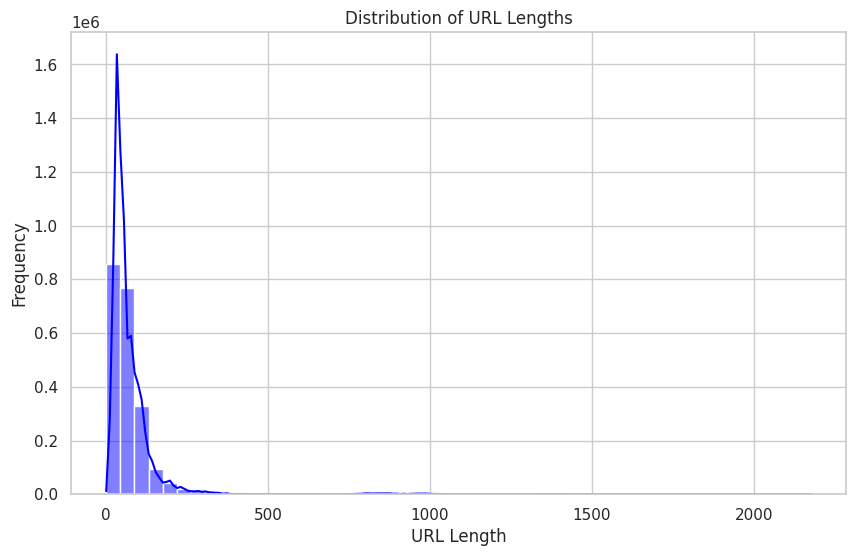

In [45]:
plt.figure(figsize=(10, 6))
sns.histplot(df_balanced['url_length'], bins=50, kde=True, color='blue')
plt.title("Distribution of URL Lengths")
plt.xlabel("URL Length")
plt.ylabel("Frequency")
plt.show()

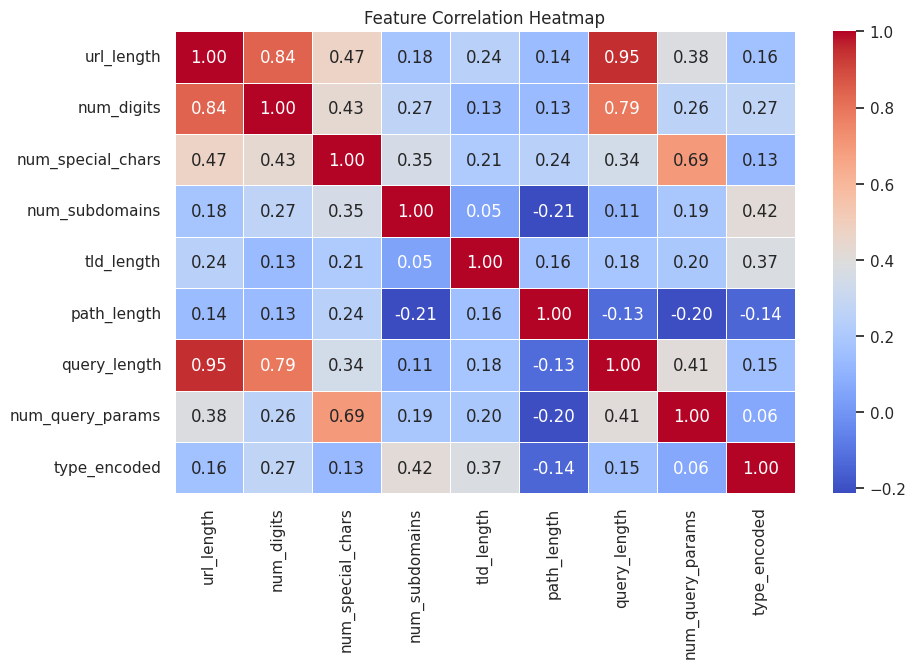

In [46]:
plt.figure(figsize=(10, 6))
corr = df_balanced.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

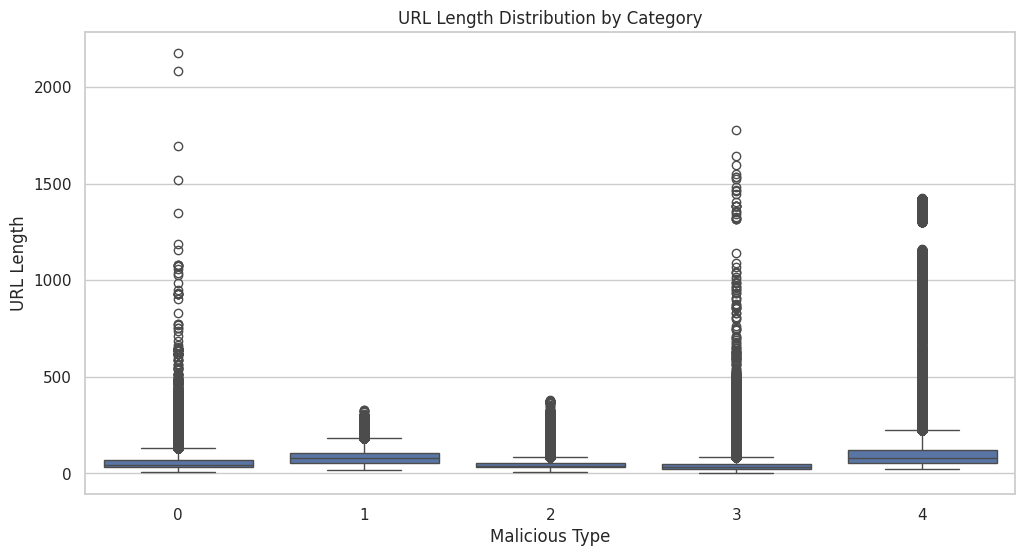

In [47]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_balanced['type_encoded'], y=df_balanced['url_length'])
plt.title("URL Length Distribution by Category")
plt.xlabel("Malicious Type")
plt.ylabel("URL Length")
plt.show()

/tmp/ipykernel_2908/766716899.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_balanced['tld_length'], palette='Set2')


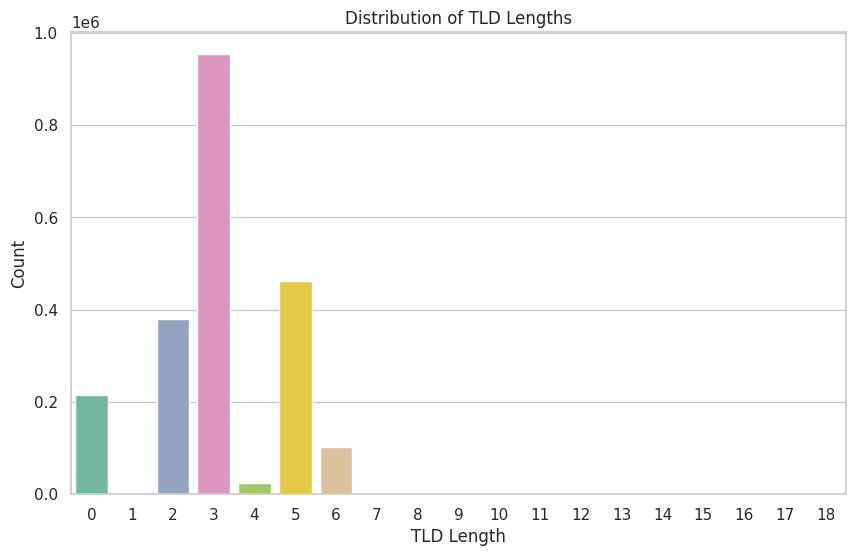

In [48]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df_balanced['tld_length'], palette='Set2')
plt.title("Distribution of TLD Lengths")
plt.xlabel("TLD Length")
plt.ylabel("Count")
plt.show()

/home/neutrino/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


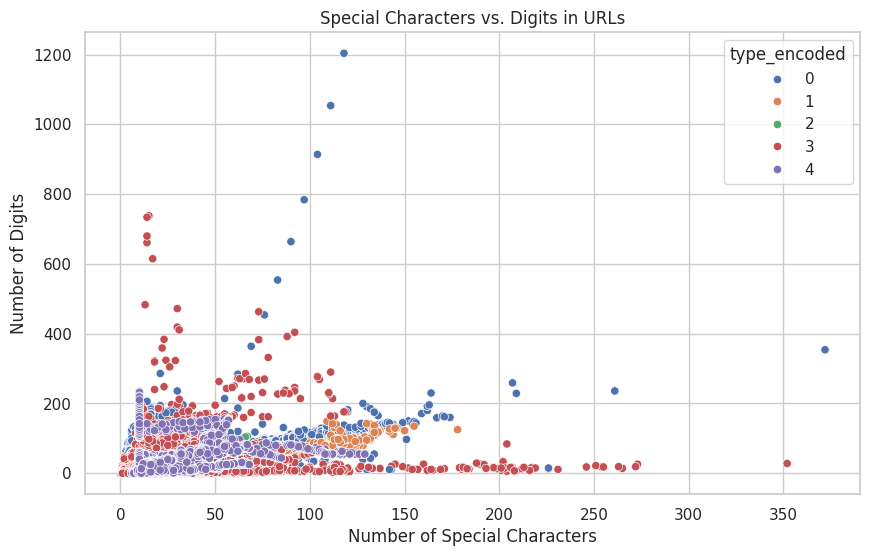

In [49]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_balanced['num_special_chars'], y=df_balanced['num_digits'], hue=df_balanced['type_encoded'], palette='deep')
plt.title("Special Characters vs. Digits in URLs")
plt.xlabel("Number of Special Characters")
plt.ylabel("Number of Digits")
plt.show()

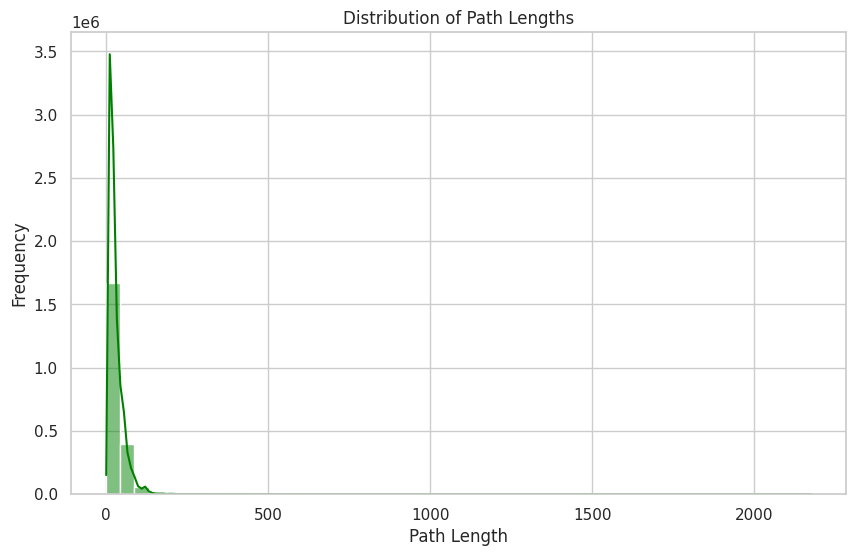

In [56]:
plt.figure(figsize=(10, 6))
sns.histplot(df_balanced['path_length'], bins=50, kde=True, color='green')
plt.title("Distribution of Path Lengths")
plt.xlabel("Path Length")
plt.ylabel("Frequency")
plt.show()

In [57]:
df_balanced.to_csv("balanced_dataset.csv", index=False)
print("Balanced dataset saved to balanced_dataset.csv")

df.to_csv("preprocessed_dataset.csv", index=False)
print("Preprocessed dataset saved to preprocessed_dataset.csv")

Balanced dataset saved to balanced_dataset.csv
Preprocessed dataset saved to preprocessed_dataset.csv


## Model Training 

In [2]:
import pandas as pd
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [3]:
NUM_TO_TYPE = {
    0: 'benign',
    1: 'defacement',
    2: 'malware',
    3: 'phishing',
    4: 'spam'
}

In [4]:
df = pd.read_csv("balanced_dataset.csv")
df

,url_length,num_digits,num_special_chars,num_subdomains,tld_length,path_length,query_length,num_query_params,type_encoded
0,83,18,16,0,2,68,0,0,0
1,83,23,17,0,2,68,0,0,0
2,83,22,17,0,2,68,0,0,0
3,83,18,19,0,2,68,0,0,0
4,83,18,17,0,2,68,0,0,0
...,...,...,...,...,...,...,...,...,...
2140395,59,13,11,2,5,22,0,0,4
2140396,52,12,11,2,5,21,0,0,4
2140397,81,27,12,2,5,55,0,0,4
2140398,108,25,16,1,5,27,53,3,4


In [5]:
df.type_encoded.value_counts()

type_encoded
0    428080
1    428080
2    428080
3    428080
4    428080
Name: count, dtype: int64

In [6]:
X = df.drop('type_encoded', axis=1)
y = df['type_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train.shape, X_test.shape

((1712320, 8), (428080, 8))

### Random Forest

In [8]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83     85547
           1       0.97      0.98      0.97     85537
           2       0.98      0.95      0.97     85711
           3       0.80      0.77      0.79     86004
           4       1.00      1.00      1.00     85281

    accuracy                           0.91    428080
   macro avg       0.91      0.91      0.91    428080
weighted avg       0.91      0.91      0.91    428080



In [9]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[72163,   141,   183, 13058,     2],
       [   99, 83753,   493,  1066,   126],
       [  672,   493, 81536,  2984,    26],
       [16081,  2275,   911, 66642,    95],
       [    5,    72,     4,    21, 85179]])

### XGBoost

In [8]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred))

/home/neutrino/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:17:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.78      0.84      0.81     85547
           1       0.89      0.96      0.92     85537
           2       0.96      0.90      0.93     85711
           3       0.76      0.68      0.72     86004
           4       0.99      0.99      0.99     85281

    accuracy                           0.87    428080
   macro avg       0.87      0.87      0.87    428080
weighted avg       0.87      0.87      0.87    428080



In [9]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[72005,   261,   186, 13087,     8],
       [  350, 82513,  1041,  1088,   545],
       [ 1001,  3296, 77031,  4239,   144],
       [19278,  6452,  1593, 58296,   385],
       [   14,   695,     9,    21, 84542]])

### DL is used in seperate file 